## Yoochoose

### Descargar Dataset

In [2]:
import pandas as pd
import os
import zipfile
import requests
from io import BytesIO

# Hay que subir el archivo primero
# Leer el archivo
df = pd.read_csv("yoochoose-clicks.dat", sep=",", header=None, names=["session_id", "timestamp", "item_id", "category"])

# Paso 1: Mostrar estadísticas básicas
print("Total de interacciones:", len(df))
print("Usuarios únicos (session_id):", df['session_id'].nunique())
print("Items únicos:", df['item_id'].nunique())

# Paso 2: Ordenar por sesión y timestamp
df = df.sort_values(by=['session_id', 'timestamp'])

# Paso 3: Crear secuencias por sesión y guardar el último timestamp como referencia
user_sequences_yo = df.groupby('session_id').agg({
    'item_id': list,
    'timestamp': 'last'  # para usar en el split temporal
}).reset_index().rename(columns={'item_id': 'item_sequence'})

# Mostrar algunas secuencias
print(user_sequences_yo.head())

Total de interacciones: 2414951
Usuarios únicos (session_id): 611271
Items únicos: 26798
   session_id                                      item_sequence  \
0           1  [214536502.0, 214536500.0, 214536506.0, 214577...   
1           2  [214662742.0, 214662742.0, 214825110.0, 214757...   
2           3            [214716935.0, 214774687.0, 214832672.0]   
3           4                         [214836765.0, 214706482.0]   
4           6                         [214701242.0, 214826623.0]   

                  timestamp  
0  2014-04-07T10:57:00.306Z  
1  2014-04-07T14:02:36.889Z  
2  2014-04-02T13:30:12.318Z  
3  2014-04-07T12:26:25.416Z  
4  2014-04-06T17:02:26.976Z  


### Filtar sesiones

In [3]:
import numpy as np
from collections import Counter

user_sequences_yo['session_length'] = user_sequences_yo['item_sequence'].apply(lambda x: len(x))
print(user_sequences_yo['session_length'].quantile(0.99))
min_len = 3
max_len = 12
user_sequences_yo = user_sequences_yo[(user_sequences_yo['session_length'] >= min_len) & (user_sequences_yo['session_length'] <= max_len)].copy()

# Aplanar todas las secuencias para contar apariciones de cada item
all_items = [item for seq in user_sequences_yo['item_sequence'] for item in seq]
item_counts = Counter(all_items)

# Crear set de items válidos (con al menos 5 apariciones)
valid_items = set(item for item, count in item_counts.items() if count >= 5)

# Función para filtrar ítems dentro de cada secuencia
def filter_sequence(seq):
    return [item for item in seq if item in valid_items]

# Aplicar filtro a cada secuencia
user_sequences_yo['item_sequence'] = user_sequences_yo['item_sequence'].apply(filter_sequence)

# Filtrar nuevamente por longitud mínima después de limpiar
user_sequences_yo['session_length'] = user_sequences_yo['item_sequence'].apply(len)
user_sequences_yo = user_sequences_yo[user_sequences_yo['session_length'] >= min_len]

#Mismas filas que retailrocket
user_sequences_yo = user_sequences_yo.sample(n=133534, random_state=42).reset_index(drop=True)

print(len(user_sequences_yo))

20.0
133534


### Visualise session lenghts

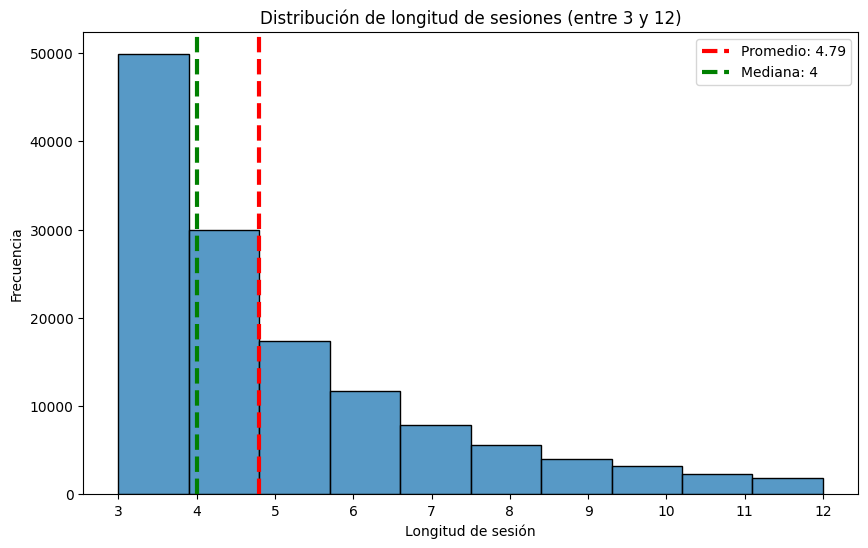

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Promedio y mediana
mean_val = user_sequences_yo['session_length'].mean()
median_val = user_sequences_yo['session_length'].median()

# Graficar histograma sin kde
plt.figure(figsize=(10, 6))
sns.histplot(user_sequences_yo['session_length'], bins=10, kde=False, edgecolor='black')

# Líneas de referencia
plt.axvline(mean_val, color='red', linestyle='--', linewidth=3, label=f'Promedio: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=3, label=f'Mediana: {median_val:.0f}')

# Detalles
plt.title('Distribución de longitud de sesiones (entre 3 y 12)')
plt.xlabel('Longitud de sesión')
plt.ylabel('Frecuencia')
plt.xticks(range(3, 13))
plt.legend()
plt.show()

## SASRec

### Instalar Torch para el modelo

In [5]:
# Reinicia el entorno después de ejecutar esto para aplicar bien todo
!pip install torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### Definir Modelo


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F

# Info GPU
print("¿CUDA disponible?:", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")

# Dataset secuencial custom
class SeqDataset(Dataset):
    def __init__(self, sequences, max_len=12):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        tokens = torch.zeros(self.max_len, dtype=torch.long)
        valid_len = min(len(seq) - 1, self.max_len)
        tokens[-valid_len:] = torch.tensor(seq[-(valid_len+1):-1], dtype=torch.long)
        target = torch.tensor(seq[-1], dtype=torch.long)
        return tokens, target

# Modelo SASRec con atención real y positional encoding
class SASRec(nn.Module):
    def __init__(self, num_items, max_len=12, embed_dim=128, num_heads=4, num_layers=2, dropout=0.2):
        super().__init__()
        self.item_emb = nn.Embedding(num_items, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_items)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand_as(x)
        x = self.item_emb(x) + self.pos_emb(positions)
        x = self.dropout(x)

        # Mask para no mirar al futuro
        attn_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=x.device), diagonal=1)
        h = self.transformer(x, mask=attn_mask)
        out = h[:, -1, :]  # Usamos solo la última posición para predecir el siguiente ítem
        return self.fc(out)


#Evaluación
def evaluate(model, dl, device, k_list=[5, 10, 20], pop_rank=None):
    model.eval()
    recalls = {k: 0 for k in k_list}
    mrrs = {k: 0 for k in k_list}
    pop_bias = {k: 0 for k in k_list}
    count = 0

    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            y = y.unsqueeze(1)

            for k in k_list:
                topk = logits.topk(k, dim=1).indices
                hit = (topk == y).any(dim=1).float()
                recalls[k] += hit.sum().item()

                ranks = (topk == y).nonzero(as_tuple=False)
                if ranks.numel() > 0:
                    mrrs[k] += (1. / (ranks[:, 1] + 1)).sum().item()

                # Popularity Bias: sumar ranking promedio
                if pop_rank:
                    pop_ranks = [pop_rank.get(int(item), len(pop_rank)+1) for item in topk.view(-1).tolist()]
                    avg_pop = np.mean(pop_ranks)
                    pop_bias[k] += avg_pop * x.size(0)  # total acumulado por batch

            count += y.size(0)

    recall_k = {f'Recall@{k}': recalls[k] / count for k in k_list}
    mrr_k = {f'MRR@{k}': mrrs[k] / count for k in k_list}
    pop_k = {f'PopBias@{k}': pop_bias[k] / count for k in k_list} if pop_rank else {}

    return recall_k, mrr_k, pop_k



def compute_ILD(topk_indices, item_embeddings):
    batch_size, k = topk_indices.shape
    ild_scores = []

    for i in range(batch_size):
        items = topk_indices[i]
        vecs = item_embeddings[items]  # (k, embed_dim)
        dists = 0.0
        count = 0
        for j in range(k):
            for l in range(j + 1, k):
                cos_sim = F.cosine_similarity(vecs[j].unsqueeze(0), vecs[l].unsqueeze(0)).item()
                dists += 1 - cos_sim
                count += 1
        if count > 0:
            ild_scores.append(dists / count)

    return sum(ild_scores) / len(ild_scores)


¿CUDA disponible?: True
Nombre de GPU: Tesla T4


### Entrenar el Modelo Yoochoose


In [ ]:
# Preparar datos para Yoochoose con split temporal
all_items_yo = sorted({i for seq in user_sequences_yo['item_sequence'] for i in seq})
id_map_yo = {i: j+1 for j, i in enumerate(all_items_yo)}
sequences_yo = [[id_map_yo[i] for i in seq] for seq in user_sequences_yo['item_sequence']]

# Temporal split (approx. 80/10/10)
# Split temporal real usando timestamp
user_sequences_yo = user_sequences_yo.sort_values(by='timestamp').reset_index(drop=True)

# Reconvertir las secuencias tras el ordenamiento
sequences_yo = [[id_map_yo[i] for i in seq] for seq in user_sequences_yo['item_sequence']]

n_yo = len(sequences_yo)
train_seqs_yo = sequences_yo[:int(0.8*n_yo)]
val_seqs_yo = sequences_yo[int(0.8*n_yo):int(0.9*n_yo)]
test_seqs_yo = sequences_yo[int(0.9*n_yo):]

from collections import Counter

# Contar ocurrencias en los datos de entrenamiento
item_freq = Counter([item for seq in train_seqs_yo for item in seq])

# Ranking de popularidad inversa: ítems populares tienen rank 1, 2, ...
sorted_items = sorted(item_freq.items(), key=lambda x: -x[1])
pop_rank = {item: rank+1 for rank, (item, _) in enumerate(sorted_items)}


train_ds_yo = SeqDataset(train_seqs_yo)
val_ds_yo = SeqDataset(val_seqs_yo)
test_ds_yo = SeqDataset(test_seqs_yo)

train_dl_yo = DataLoader(train_ds_yo, batch_size=128, shuffle=True)
val_dl_yo = DataLoader(val_ds_yo, batch_size=128)
test_dl_yo = DataLoader(test_ds_yo, batch_size=128)

# Entrenar modelo Yoochoose
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_yo = SASRec(num_items=len(all_items_yo)+1, max_len=12).to(device)
opt_yo = torch.optim.Adam(model_yo.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

print("Entrenando modelo para Yoochoose:")
for epoch in range(20):
    model_yo.train()
    total = 0
    for x, y in train_dl_yo:
        x, y = x.to(device), y.to(device)
        logits = model_yo(x)
        loss = loss_fn(logits, y)
        opt_yo.zero_grad()
        loss.backward()
        opt_yo.step()
        total += loss.item()
    print(f"Epoch {epoch+1} loss: {total/len(train_dl_yo):.4f}")

# Guardar el modelo
torch.save(model_yo.state_dict(), 'models/sasrec_yc.pth')

Entrenando modelo para Yoochoose:
Epoch 1 loss: 7.4596
Epoch 2 loss: 6.0485
Epoch 3 loss: 5.3762
Epoch 4 loss: 4.8824
Epoch 5 loss: 4.4821
Epoch 6 loss: 4.1542
Epoch 7 loss: 3.8853
Epoch 8 loss: 3.6703
Epoch 9 loss: 3.5031
Epoch 10 loss: 3.3655
Epoch 11 loss: 3.2595
Epoch 12 loss: 3.1737
Epoch 13 loss: 3.0973
Epoch 14 loss: 3.0396
Epoch 15 loss: 2.9914
Epoch 16 loss: 2.9387
Epoch 17 loss: 2.8988
Epoch 18 loss: 2.8548
Epoch 19 loss: 2.8190
Epoch 20 loss: 2.7887


### Metricas

In [9]:
r_yo, m_yo, p_yo = evaluate(model_yo, test_dl_yo, device, pop_rank=pop_rank)
print("RetailRocket - Métricas de evaluación:")

for k in r_yo: print(f"{k}: {r_yo[k]:.4f}")
for k in m_yo: print(f"{k}: {m_yo[k]:.4f}")
for k in p_yo: print(f"{k}: {p_yo[k]:.2f}")


def compute_ild_for_model(model, dataloader, device, k=20):
    model.eval()
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            logits = model(x)
            topk = logits.topk(k, dim=1).indices
            embeddings = model.item_emb.weight.data  # (num_items, embed_dim)
            ild = compute_ILD(topk.cpu(), embeddings.cpu())
            return ild  # Devuelve el ILD@k solo de la primera minibatch

ild_20 = compute_ild_for_model(model_yo, test_dl_yo, device, k=20)
ild_10 = compute_ild_for_model(model_yo, test_dl_yo, device, k=10)
ild_5 = compute_ild_for_model(model_yo, test_dl_yo, device, k=5)
print(f"ILD@20: {ild_20:.4f}")
print(f"ILD@10: {ild_10:.4f}")
print(f"ILD@5: {ild_5:.4f}")

RetailRocket - Métricas de evaluación:
Recall@5: 0.3876
Recall@10: 0.4583
Recall@20: 0.5079
MRR@5: 0.2533
MRR@10: 0.2628
MRR@20: 0.2664
PopBias@5: 1253.02
PopBias@10: 1192.52
PopBias@20: 1163.82
ILD@20: 0.9615
ILD@10: 0.9466
ILD@5: 0.9362
